In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

Средняя дисперсия цены внутри бинов: 9194.361823986414


C:\Users\skapr\AppData\Local\Temp\ipykernel_12300\2004207209.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_variance_in_bins = df.groupby('bin')['цена_за_кв_м'].var().mean()


<Figure size 1000x600 with 0 Axes>

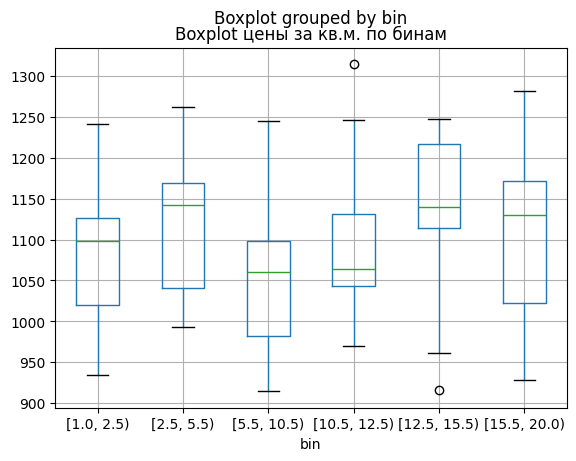

C:\Users\skapr\AppData\Local\Temp\ipykernel_12300\2004207209.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('bin')['цена_за_кв_м'].mean().plot(kind = 'bar')


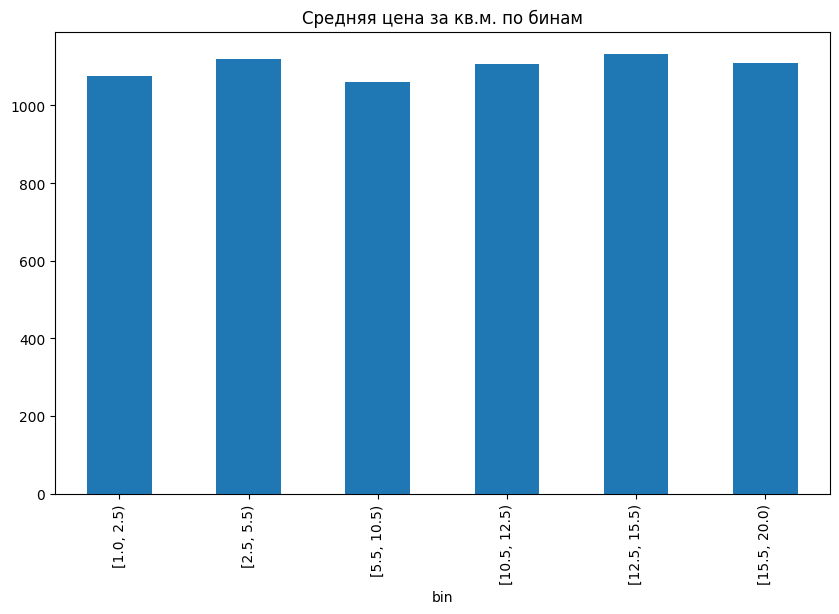

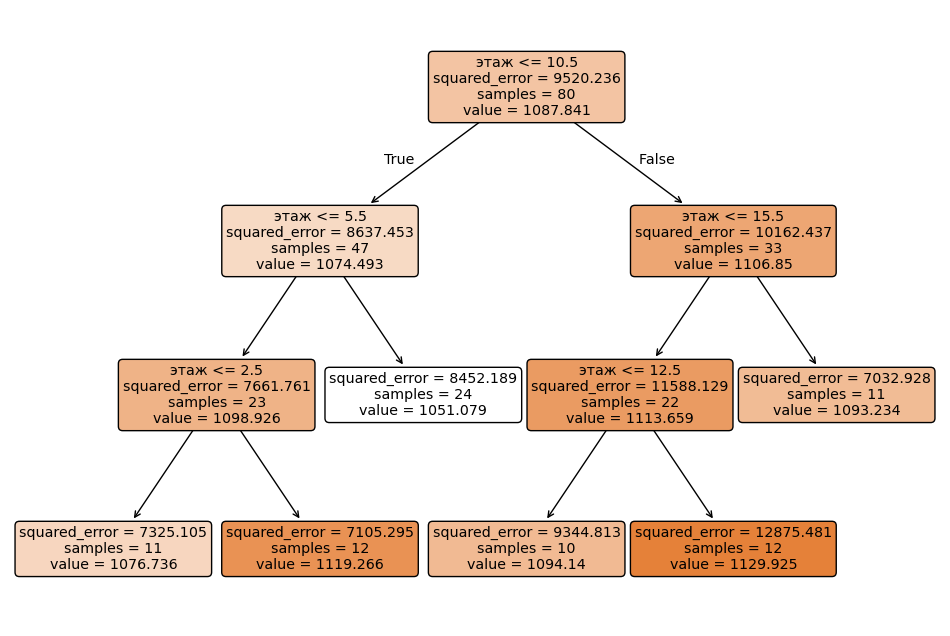

In [31]:
# Перед тем, как делать бининг необходимо исключить первые и последние этажи

# Пример данных (замените на ваши данные)
np.random.seed(42)
n_samples = 100
data = {
    'этаж': np.random.randint(1, 20, n_samples),
    'цена_за_кв_м': 1000 + 50 * np.random.randn(n_samples) + 100 * np.random.randint(0, 3, n_samples) # Убрана зависимость от этажа для большей наглядности
}
df = pd.DataFrame(data)

# Подготовка данных
X = df[['этаж']]
y = df['цена_за_кв_м']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Обучение дерева решений (с автоматическим определением числа бинов)
model = DecisionTreeRegressor(max_depth = 3, 
                              min_samples_leaf = 10, 
                              random_state = 42
                             ) #настраиваемые параметры
model.fit(X_train, y_train)


# Получение границ бинов из дерева решений (более корректный способ)
n_nodes = model.tree_.node_count
thresholds = []
for i in range(n_nodes):
    if model.tree_.children_left[i] != -1:  # только узлы, где происходит разбиение (-1 в узле нет разбиения)
        thresholds.append(model.tree_.threshold[i]) # вытаскиваем пороги разбиения

thresholds.sort()
left_borders = [X['этаж'].min()] + list(thresholds)
right_borders = list(thresholds) + [X['этаж'].max() + 1]

# Создание бинов
bins = pd.cut(df['этаж'], bins = left_borders + [right_borders[-1]], right = False, include_lowest = True)
df['bin'] = bins #.cat.codes + 1 # преобразование в числовое представление

# Оценка качества бининга (более адекватная оценка)
# Оцениваем однородность внутри бинов (низкая дисперсия - хорошо)
average_variance_in_bins = df.groupby('bin')['цена_за_кв_м'].var().mean()
print(f'Средняя дисперсия цены внутри бинов: {average_variance_in_bins}')

# Визуализация
plt.figure(figsize = (10, 6))
df.boxplot(column = 'цена_за_кв_м', by = 'bin')
plt.title('Boxplot цены за кв.м. по бинам')
plt.show()

plt.figure(figsize = (10, 6))
df.groupby('bin')['цена_за_кв_м'].mean().plot(kind = 'bar')
plt.title('Средняя цена за кв.м. по бинам')
plt.show()

# Визуализация дерева
plt.figure(figsize = (12, 8))
plot_tree(model, feature_names = ['этаж'], filled = True, rounded = True)
plt.show()